# start

In [1]:
SEED = 101

In [2]:
PRFX = f'CV0815_1'

In [3]:
p_o = f'../output/{PRFX}'

# p_o = f'.'

from pathlib import Path
Path(p_o).mkdir(exist_ok=True, parents=True)


In [4]:
dbg = False
if dbg: dbgsz=1000

from fastai.vision import * 

In [5]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

In [6]:
!nvidia-smi

Thu Aug 15 17:23:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    42W / 300W |     10MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

# params

In [8]:
BS = 16
FP16 = True
PERC_VAL = 0.1
WD = 0.01


MODEL_NAME = 'efficientnet-b5'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))
print('SZ:', SZ)

efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 456


## img proc

In [9]:
use_open_yz = True

from fastai.vision import *
import cv2
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)
    image = center_crop(image)
    image = cv2.resize(image, (640, 480))#most common in test
#     image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

> get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

In [10]:
params_tfms = dict(
    do_flip=True,
    flip_vert=True,
    max_rotate=360,
)

> By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (ResizeMethod.CROP). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (ResizeMethod.PAD). Another way is to just squish the image to the given size (ResizeMethod.SQUISH).

In [11]:
kwargs_tfms = dict(
    resize_method=ResizeMethod.SQUISH,
    padding_mode='zeros'
)

# setup

In [12]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## set seed

In [13]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False
set_torch_seed()

## image processing

In [14]:
import cv2

def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
if use_open_yz:
    vision.data.open_image = open_yz

## QWK

In [15]:
import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def qwk(y_pred, y):
    return torch.tensor(
#         quadratic_weighted_kappa(torch.round(y_pred), y),
        quadratic_weighted_kappa(np.argmax(y_pred,1), y),
        device='cuda:0')

## TTTA

In [16]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

# preprocess

## prep

In [17]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [18]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [19]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)
train=pd.read_csv(pp/'trainLabels.csv')
test=pd.read_csv(pp/'retinopathy_solution.csv')

img2grd_diab_train=[(f'{p}/train_images/{o[0]}.jpeg', o[1], 'diab')  for o in train.values]
img2grd_diab_test =[(f'{p}/test_images/{o[0]}.jpeg',  o[1], 'diab')  for o in test.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [20]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)
train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

img2grd_idrid_train=[(f'{p}/1. Original Images/a. Training Set/{o[0]}.jpg', o[1], 'idri')  for o in train.values]
img2grd_idrid_test =[(f'{p}/1. Original Images/b. Testing Set/{o[0]}.jpg',  o[1], 'idri')  for o in test.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

92880

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [21]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']
df = df.reset_index()
df.shape

(92880, 4)

In [22]:
df.sample(5).values

array([[45576, '../input/diabetic-retinopathy-detection/test_images/5630_left.jpeg', 1, 'diab'],
       [57971, '../input/diabetic-retinopathy-detection/test_images/15950_right.jpeg', 0, 'diab'],
       [56703, '../input/diabetic-retinopathy-detection/test_images/14888_right.jpeg', 0, 'diab'],
       [38742, '../input/diabetic-retinopathy-detection/train_images/44282_left.jpeg', 0, 'diab'],
       [20151, '../input/diabetic-retinopathy-detection/train_images/20670_right.jpeg', 0, 'diab']], dtype=object)

In [23]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

## df2use

In [24]:
df.target.value_counts()

0    67316
2    14320
1     6600
3     2373
4     2271
Name: target, dtype: int64

In [25]:
df2use = df[df.src=='blnd'].copy()

df2use.target.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: target, dtype: int64

In [26]:
def get_randint(low=200, high=1000):
    res = np.random.randn()*300+600
    return int(min(max(low, res), high))

set_torch_seed()
n_t_extra = {2:get_randint(),
             3:get_randint(),
             4:get_randint(),
             1:get_randint()
            }
n_t_extra

{2: 1000, 3: 788, 4: 872, 1: 751}

In [27]:
set_torch_seed()
for t,n in n_t_extra.items():
    df_t_non_blnd = df[(df.target==t) & (df.src!='blnd')]
    df2use = pd.concat([df2use, df_t_non_blnd.sample(min(n, len(df_t_non_blnd)))])

In [28]:
df2use.shape

(7073, 4)

In [29]:
df2use.target.value_counts()

2    1999
0    1805
4    1167
1    1121
3     981
Name: target, dtype: int64

## add val

In [30]:
fnms2use = set(df2use.fnm)
df_maybe_val = df[~df.fnm.isin(fnms2use)]
df.shape, df2use.shape, df_maybe_val.shape

((92880, 4), (7073, 4), (85807, 4))

In [31]:
lst_df_val = []
for t in range(5):
    lst_df_val.append(df_maybe_val[df_maybe_val.target==t].sample(300))

df_val = pd.concat(lst_df_val)
display(df_val.shape)
df_val.target.value_counts()

(1500, 4)

4    300
3    300
2    300
1    300
0    300
Name: target, dtype: int64

In [32]:
df2use['is_val'] = False
df_val['is_val'] = True
df2use_trnval = pd.concat([df2use, df_val])
display(df2use_trnval.shape)

(8573, 5)

In [33]:
df2use_trnval.is_val.value_counts()

False    7073
True     1500
Name: is_val, dtype: int64

In [34]:
df2use_trnval[~df2use_trnval.is_val].src.value_counts()

blnd    3662
diab    3345
idri      66
Name: src, dtype: int64

In [35]:
df2use_trnval[df2use_trnval.is_val].src.value_counts()

diab    1475
idri      25
Name: src, dtype: int64

In [36]:
df2use_trnval.sample(5)

,index,fnm,target,src,is_val
71950,71950,../input/diabetic-retinopathy-detection/test_i...,4,diab,False
19729,19729,../input/diabetic-retinopathy-detection/train_...,4,diab,False
48142,48142,../input/diabetic-retinopathy-detection/test_i...,2,diab,False
49904,49904,../input/diabetic-retinopathy-detection/test_i...,2,diab,False
2490,2490,../input/aptos2019-blindness-detection/train_i...,0,blnd,False


In [37]:
if dbg: 
    df2use_trnval = df2use_trnval.sample(dbgsz)

## dataset

In [38]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz=SZ, bs=BS):
    src = (ImageList.from_df(df=df2use_trnval,path='./',cols='fnm') 
#             .split_none()
            .split_from_df(col='is_val')
            .label_from_df(cols='target',  
                           #label_cls=FloatList
                          )
          )

    data= (src.transform(tfms, size=sz,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data


set_torch_seed()
data = get_data()

CPU times: user 13.7 s, sys: 783 ms, total: 14.4 s
Wall time: 11.3 s


## add test dataset

In [39]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
test  = pd.read_csv(pp/'test.csv')

In [40]:
if dbg: test = test.head(dbgsz)

In [41]:
data.add_test(ImageList.from_df(test,
                                '../input/aptos2019-blindness-detection',
                                folder='test_images',
                                suffix='.png'))

# train

In [42]:
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=5) 
learn = Learner(data, model, path=p_o, 
#                 wd=WD,  
                metrics=[accuracy, qwk],
               )
if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


In [43]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 36.3 s, sys: 5.05 s, total: 41.4 s
Wall time: 2min 23s


In [44]:
!nvidia-smi

Thu Aug 15 17:26:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    43W / 300W |  15435MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Min numerical gradient: 1.74E-03
Min loss divided by 10: 9.12E-04


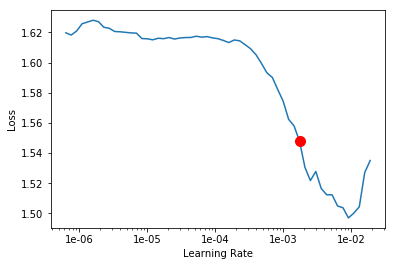

In [45]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [46]:
set_torch_seed()
learn.fit_one_cycle(20, max_lr=5e-4, 
                    callbacks=[SaveModelCallback(learn, 
#                                                  every='epoch', 
                                                 name=f'{PRFX}_model')]
                   )



epoch,train_loss,valid_loss,accuracy,qwk,time
0,1.045771,1.351293,0.395333,-0.001628,12:39
1,0.868319,1.566308,0.472667,0.000677,12:41
2,0.787604,1.569832,0.480667,nan,12:42
3,0.815868,2.030630,0.442667,nan,12:55


Better model found at epoch 0 with valid_loss value: 1.3512928485870361.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


KeyboardInterrupt: 

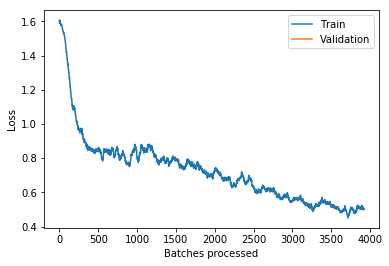

In [42]:
learn.recorder.plot_losses()

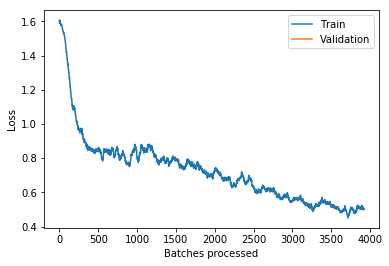

In [42]:
learn.recorder.plot_metrics()

# testing

In [43]:
learn = learn.to_fp32()

In [44]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()
preds_tst = np.argmax(preds_tst, 1)

CPU times: user 13.5 s, sys: 4.59 s, total: 18.1 s
Wall time: 49.7 s


In [45]:
%%time
set_torch_seed()
preds_tst_tta, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tst_tta = preds_tst_tta.numpy().squeeze()
preds_tst_tta = np.argmax(preds_tst_tta, 1)

CPU times: user 1min 17s, sys: 25.5 s, total: 1min 42s
Wall time: 5min 23s


In [46]:
pd.Series(preds_tst.astype(int)).value_counts()

2    1236
0     356
1     136
4     122
3      78
dtype: int64

In [47]:
pd.Series(preds_tst_tta.astype(int)).value_counts()

2    1250
0     359
1     120
4     108
3      91
dtype: int64

## submit

In [48]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,4
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [49]:
subm.diagnosis.value_counts()

2    1236
0     356
1     136
4     122
3      78
Name: diagnosis, dtype: int64

In [50]:
subm.to_csv(f"{p_o}/submission.csv", index=False)